In [1]:
import re
from rich import print

def name_group(pattern):
    return re.sub('{(.)}', r'(?P<\1>.+?)', pattern)

def Rule(output, *patterns):
    return (output, [name_group(pattern) + '$' for pattern in patterns])
            
def word(w):
    return r'\b' + w + r'\b'
    
def clean(text) -> str: 
    return ' '.join(text.split()).replace("’", "'").rstrip('.').rstrip(',')

In [2]:
re.match(r"if (?P<P>.+) then (?P<Q>.+)$","if something something then something2 something2").group()

'if something something then something2 something2'

In [3]:
Rule('{P} ⇒ {Q}', 'if {P} then {Q}', 'if {P}, {Q}')


('{P} ⇒ {Q}', ['if (?P<P>.+?) then (?P<Q>.+?)$', 'if (?P<P>.+?), (?P<Q>.+?)$'])

In [4]:
pattern_rules = [
    Rule('{P} ⇒ {Q}',         'if {P} then {Q}', 'if {P}, {Q}',
                                '{Q} provided that {P}', '{Q} whenever {P}', 
                               '{P} implies {Q}', '{P} therefore {Q}', 
                               '{Q}, if {P}', '{Q} if {P}', '{P} only if {Q}'),
    Rule('{P} ⋁ {Q}',          'either {P} or else {Q}', 'either {P} or {Q}'),
    Rule('{P} ⋀ {Q}',          'both {P} and {Q}'),
    Rule('¬{P} ⋀ ¬{Q}',       'neither {P} nor {Q}'),
    Rule('¬{A}{P} ⋀ ¬{A}{Q}', '{A} neither {P} nor {Q}'),
    Rule('¬{Q} ⇒ {P}',        '{P} unless {Q}'),
    Rule('{P} ⋀ {Q}',          '{P} and {Q}', '{P} but {Q}'),
    Rule('{P} ⋁ {Q}',          '{P} or else {Q}', '{P} or {Q}'),
    ]

negations = [
    (word("not"), ""),
    (word("cannot"), "can"),
    (word("can't"), "can"),
    (word("won't"), "will"),
    (word("ain't"), "is"),
    (word("isn't"), "is"),
    ("n't", ""),
    ]

operators = {"⋁":" or ", "⋀":" and ", "⇒":" implies ", "¬":" not "}

In [5]:
def match_rules(sentence, defs) -> tuple:
    sentence = clean(sentence)
    for rule in pattern_rules:
        result = match_rule(sentence, rule, defs)
        if result: 
            return result
    return match_literal(sentence, negations, defs)
        
def match_rule(sentence, rule, defs) -> tuple:
    output, patterns = rule
    for pattern in patterns:
        match = re.match(pattern, sentence, flags=re.I)
        if match:
            groups = match.groupdict()
            for P in sorted(groups):
                groups[P] = match_rules(groups[P], defs)[0]
            return '(' + output.format(**groups) + ')', defs
        
def match_literal(sentence, negations, defs) -> tuple:
    polarity = ''
    for (neg, pos) in negations:
        (sentence, n) = re.subn(neg, pos, sentence, flags=re.I)
        polarity += n * '¬'
    sentence = clean(sentence)
    P = proposition_name(sentence, defs)
    defs[P] = sentence
    return polarity + P, defs
    
def proposition_name(sentence, defs):
    inverted = {defs[P]: P for P in defs}
    if sentence in inverted:
        return inverted[sentence]                      # Find previously-used name
    else:
        return next(P for P in 'PQRSTUVWXYZABCDEFGHJKLMNO' if P not in defs)

In [6]:
match_rule("If i win, you won't win",
           Rule('{P} ⇒ {Q}', 'if {P}, {Q}'),
           {})

('(P ⇒ ¬Q)', {'P': 'i win', 'Q': 'you will win'})

In [7]:
def logic(sentence:str, defs:dict): 
    logic, defs = match_rules(sentence, defs)
    print('[#22ddff]English:[/] ' + sentence +'.', '[#22ff88]\nLogic:[/]', logic, end="")
    return logic

premises = []
defs = {}

def takeInput():  
    sentence = clean(input("write your logic statement: "))
    if sentence:
        premises.append(logic(sentence, defs))
        return takeInput()
    else:
        return
    
def printNotations():
    text = '[#ffaaff]Notations:[/]\n'
    for P in sorted(defs):
        text += f'\n  [#ff22aa]{P}:[/] {defs[P]}'

    if len(defs) != 0:
        print(text)
        
takeInput()
printNotations()

In [8]:

class inference_rule():
    def __init__(self, name:str, *patterns) -> None:
        self.name = name
        self.patterns = patterns

inference_rules = [
    inference_rule("modus ponenus", r"\(?(.+?) ⋀ \(?\1 ⇒ (?P<conclusion>¬?.+?)\)?\)?$"),
    inference_rule("modus tollens", r"\(?¬(.+?) \(?⋀ (.+?) ⇒ (?P<conclusion>(\1))\)?\(?$"),
    inference_rule("hypothetical syllogism", r"\(?\(?(?P<conclusion>.+?) ⇒ (.+?)\)? ⋀ \(?(\2) ⇒ (?P<conclusion2>.+?)\)?\)?$"),
    inference_rule("disjunctive syllogism", r"\(?\(?(.+?) ⋁ (?P<conclusion>.+?)\)? ⋀ ¬\1\)?$"),
    inference_rule("resolution", r"\(?\(?(?P<conclusion>.+?) ⋁ (.+?)\)? ⋀ \(?¬\2 ⋁ (?P<conclusion2>.+?)\)?\)?$", r"\(?\(?(.+?) ⋁ (?P<conclusion>.+?)\)? ⋀ \(?¬\1 ⋁ (?P<conclusion2>.+?)\)?\)?$")
]
conclusion = premises.copy()
def evaluate(premise):
    print(premise)
    for i in range(0,len(premise)):
        for j in range(0,len(premise)):
            if i == j: continue
            for rule in inference_rules:
                for pattern in rule.patterns:
                    expression = premise[i] + " ⋀ " + premise[j] # tries conjunction with each pair of permutations
                    match = re.match(pattern, expression)
                    if match:
                        conclusion = match.group("conclusion")
                        if rule.name == "modus tollens":
                            conclusion = "¬"+match.group("conclusion")
                        elif rule.name == "hypothetical syllogism":
                            conclusion = "("+ match.group("conclusion") + " ⇒ " + match.group("conclusion2")+")"
                        elif rule.name == "resolution":
                            conclusion = "(" + match.group("conclusion") + " ⋁ " + match.group("conclusion2") + ")"
                        premise.pop(max(i,j))
                        premise.pop(min(i,j))
                        premise.append(conclusion)
                        print("[#ff88ff]"+expression+"[#22ff55] by Using "+rule.name+f"\n[#ff88ff]{conclusion}[/]")
                        return evaluate(premise)
    return

evaluate(conclusion)
englishStatement = ""
for i in conclusion:
    for letter in i:
        if letter in defs:
            englishStatement += defs[letter]
        elif letter in operators:
            englishStatement += operators[letter]
    englishStatement += "\n"

printNotations()
print("[#2299ff]Final Conclusion: [#aaddff]"+englishStatement)

[]

Final Conclusion: 

In [9]:
re.match(r"\(?(.+?) ⋀ \(?\1 ⇒ (?P<conclusion>¬?.+?)\)?\)?$", "(P or Q) ⋀ ((P or Q) ⇒ R)").group("conclusion")

'R'

In [10]:
# Modus ponenus RegEx
re.match(r"\(?(.+?) ⋀ \(?\1 ⇒ (?P<conclusion>¬?.+?)\)?\)?$", "P ⋀ (P ⇒ S)")

<re.Match object; span=(0, 11), match='P ⋀ (P ⇒ S)'>

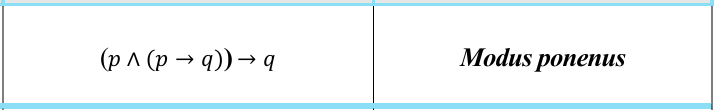

In [11]:
# Modus tollens RegEx
re.match(r"¬(.+?) ⋀ \(?(?P<conclusion>(.+?)) ⇒ (\1)\)?$", "¬(Q ⋀ R) ⋀ (P ⇒ (Q ⋀ R))")

<re.Match object; span=(0, 24), match='¬(Q ⋀ R) ⋀ (P ⇒ (Q ⋀ R))'>

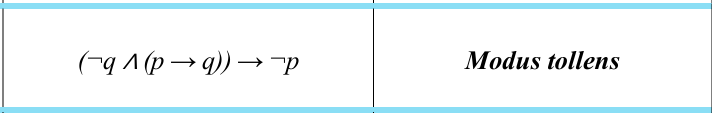

In [12]:
# Hypothetical Syllogism
re.match(r"\(?(?P<conclusion>.+?) ⇒ (.+?)\)? ⋀ \(?(\2) ⇒ (?P<conclusion2>.+?)\)?$", "P ⇒ Q ⋀ Q ⇒ R")

<re.Match object; span=(0, 13), match='P ⇒ Q ⋀ Q ⇒ R'>

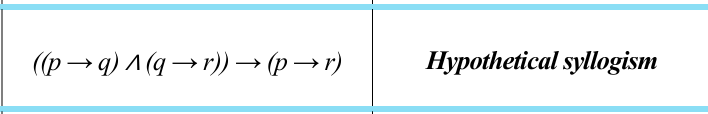

In [13]:
# Disjunctive syllogism
re.match(r"\(?(.+?) ⋁ (?P<conclusion>.+?)\)? ⋀ ¬\1$", "(P ⋁ Q) ⋀ ¬P")

<re.Match object; span=(0, 12), match='(P ⋁ Q) ⋀ ¬P'>

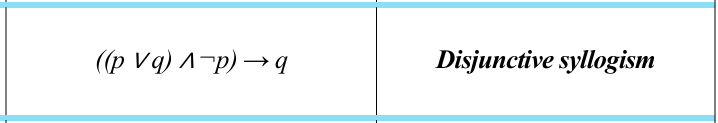

In [14]:
# Resolution
re.match(r"\(?(?P<conclusion>.+?) ⋁ (.+?)\)? ⋀ \(?¬\2 ⋁ (?P<conclusion2>.+?)\)?$", "(P ⋁ Q) ⋀ (¬Q ⋁ R)")

<re.Match object; span=(0, 18), match='(P ⋁ Q) ⋀ (¬Q ⋁ R)'>

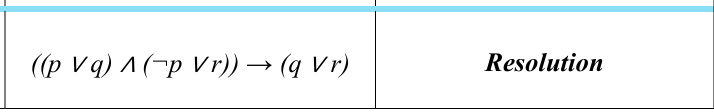